In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

spark = SparkSession.builder \
    .appName("TotalTripTimeExample") \
    .getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pyspark.sql
from pyspark.sql import Row
from pyspark.sql.types import *
import json

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col,expr, unix_timestamp, coalesce
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F

In [ ]:
data=spark.read.format("csv").option("header","true").load("/content/drive/MyDrive/nyc_taxi.csv")
data.show()

+-----------+-----------+------------+------------+--------+----+-----+
|pickup_date|pickup_time|dropoff_date|dropoff_time|distance| tip| fare|
+-----------+-----------+------------+------------+--------+----+-----+
|   1/1/2017|       0:00|    1/1/2017|        0:00|    0.02|   0| 52.8|
|   1/1/2017|       0:00|    1/1/2017|        0:03|     0.5|   0|  5.3|
|   1/1/2017|       0:00|    1/1/2017|        0:39|    7.75|4.66|27.96|
|   1/1/2017|       0:00|    1/1/2017|        0:06|     0.8|1.45| 8.75|
|   1/1/2017|       0:00|    1/1/2017|        0:08|     0.9|   0|  8.3|
|   1/1/2017|       0:00|    1/1/2017|        0:05|    1.76|   0|  8.3|
|   1/1/2017|       0:00|    1/1/2017|        0:15|    8.47|7.71|38.55|
|   1/1/2017|       0:00|    1/1/2017|        0:11|     2.4|   0| 11.8|
|   1/1/2017|       0:00|    1/1/2017|        0:23|    12.6|  10| 70.3|
|   1/1/2017|       0:00|    1/1/2017|        0:08|     0.9|2.05|10.35|
|   1/1/2017|       0:00|    1/1/2017|        0:09|    2.43| 2.7

### **Using Spark MLlib build a model to predict taxi fare from trip distance (Model: M1)**

In [ ]:
data = data.withColumn("distance", col("distance").cast("double"))
data = data.withColumn("fare", col("fare").cast("double"))
feature_column=['distance']
label_column='fare'
assembler=VectorAssembler(inputCols=feature_column,outputCol='features')
df_assembler=assembler.transform(data)
training_data,testing_data=df_assembler.randomSplit([0.7,0.3],seed=100)

In [ ]:
model=LinearRegression(featuresCol='features',labelCol=label_column)
lr=model.fit(training_data)

In [ ]:
predictions=lr.transform(testing_data)
predictions.show()

+-----------+-----------+------------+------------+--------+----+-----+--------+------------------+
|pickup_date|pickup_time|dropoff_date|dropoff_time|distance| tip| fare|features|        prediction|
+-----------+-----------+------------+------------+--------+----+-----+--------+------------------+
|   1/1/2017|       0:00|    1/1/2017|        0:01|     0.1|   0|  4.3|   [0.1]| 7.257859468598113|
|   1/1/2017|       0:00|    1/1/2017|        0:03|    0.56|   0|  5.8|  [0.56]| 8.693181547221736|
|   1/1/2017|       0:00|    1/1/2017|        0:03|     0.9|   0|  6.3|   [0.9]|  9.75407177924789|
|   1/1/2017|       0:00|    1/1/2017|        0:04|     0.4|   0|  5.8|   [0.4]|  8.19393908509178|
|   1/1/2017|       0:00|    1/1/2017|        0:04|     0.6|   0|  6.3|   [0.6]| 8.817992162754225|
|   1/1/2017|       0:00|    1/1/2017|        0:05|     0.6|1.16| 6.96|   [0.6]| 8.817992162754225|
|   1/1/2017|       0:00|    1/1/2017|        0:05|     0.9|   0|  7.3|   [0.9]|  9.75407177924789|


### **Using Spark MLlib build a model to predict taxi fare from trip distance and trip duration in minutes (Model: M2). M2 will have two features**

In [ ]:
evaluator1 = RegressionEvaluator(labelCol=label_column, predictionCol="prediction", metricName="rmse")
rmse1 = evaluator1.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data: {rmse1}")

Root Mean Squared Error (RMSE) on test data: 5.794842309285673


In [ ]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [ ]:
data = data.withColumn("pickup_datetime", unix_timestamp("pickup_date", "MM/dd/yyyy") + unix_timestamp("pickup_time", "HH:mm").cast("double"))
data = data.withColumn("dropoff_datetime", unix_timestamp("dropoff_date", "MM/dd/yyyy") + unix_timestamp("dropoff_time", "HH:mm").cast("double"))
data = data.withColumn("trip_duration_minutes", ((col("dropoff_datetime") - col("pickup_datetime")) / 60).cast("double"))

In [ ]:
data.show()

+-----------+-----------+------------+------------+--------+----+-----+---------------+----------------+---------------------+
|pickup_date|pickup_time|dropoff_date|dropoff_time|distance| tip| fare|pickup_datetime|dropoff_datetime|trip_duration_minutes|
+-----------+-----------+------------+------------+--------+----+-----+---------------+----------------+---------------------+
|   1/1/2017|       0:00|    1/1/2017|        0:00|    0.02|   0| 52.8|    1.4832288E9|     1.4832288E9|                  0.0|
|   1/1/2017|       0:00|    1/1/2017|        0:03|     0.5|   0|  5.3|    1.4832288E9|    1.48322898E9|                  3.0|
|   1/1/2017|       0:00|    1/1/2017|        0:39|    7.75|4.66|27.96|    1.4832288E9|    1.48323114E9|                 39.0|
|   1/1/2017|       0:00|    1/1/2017|        0:06|     0.8|1.45| 8.75|    1.4832288E9|    1.48322916E9|                  6.0|
|   1/1/2017|       0:00|    1/1/2017|        0:08|     0.9|   0|  8.3|    1.4832288E9|    1.48322928E9|       

In [ ]:
features_column=['trip_duration_minutes','distance']
assembler1=VectorAssembler(inputCols=features_column,outputCol='features1')
df1_assembler=assembler1.transform(data)
training_data1,testing_data1=df1_assembler.randomSplit([0.7,0.3],seed=100)

In [ ]:
model2=LinearRegression(featuresCol='features1',labelCol=label_column)
lr1=model2.fit(training_data1)

In [ ]:
predictions1=lr1.transform(testing_data1)

In [ ]:
predictions1.show()

+-----------+-----------+------------+------------+--------+----+-----+---------------+----------------+---------------------+-----------+------------------+
|pickup_date|pickup_time|dropoff_date|dropoff_time|distance| tip| fare|pickup_datetime|dropoff_datetime|trip_duration_minutes|  features1|        prediction|
+-----------+-----------+------------+------------+--------+----+-----+---------------+----------------+---------------------+-----------+------------------+
|   1/1/2017|       0:00|    1/1/2017|        0:01|     0.1|   0|  4.3|    1.4832288E9|    1.48322886E9|                  1.0|  [1.0,0.1]| 7.175072269750122|
|   1/1/2017|       0:00|    1/1/2017|        0:03|    0.56|   0|  5.8|    1.4832288E9|    1.48322898E9|                  3.0| [3.0,0.56]| 8.621197827140925|
|   1/1/2017|       0:00|    1/1/2017|        0:03|     0.9|   0|  6.3|    1.4832288E9|    1.48322898E9|                  3.0|  [3.0,0.9]| 9.673980538318524|
|   1/1/2017|       0:00|    1/1/2017|        0:04| 

In [ ]:
evaluator2 = RegressionEvaluator(labelCol=label_column, predictionCol="prediction", metricName="rmse")
rmse2 = evaluator2.evaluate(predictions1)

print(f"Root Mean Squared Error (RMSE) on test data: {rmse2}")

Root Mean Squared Error (RMSE) on test data: 5.8061672234759305


### **What is the fare of a 20 mile long trip using M1**

In [ ]:
from pyspark.sql import Row

row = Row(distance=20.0)

data_to_predict_m1 = spark.createDataFrame([row])
data_to_predict_m1 = assembler.transform(data_to_predict_m1)
prediction_m1 = lr.transform(data_to_predict_m1)
predicted_fare_m1 = prediction_m1.select("prediction")

print("Fare of a 20 mile long trip",predicted_fare_m1.collect()[0][0])


Fare of a 20 mile long trip 69.35114069601134


### **What is the fare of a 14 mile trip that took 75 minutes using M2**

In [ ]:
row1 = Row(distance=14.0, trip_duration_minutes=75.0)

data_to_predict_m2 = spark.createDataFrame([row1])
data_to_predict_m2 = assembler1.transform(data_to_predict_m2)
prediction_m2 = lr1.transform(data_to_predict_m2)
predicted_fare_m2 = prediction_m2.select("prediction")

print("Fare of a 14 mile trip",predicted_fare_m2.collect()[0][0])

Fare of a 14 mile trip 51.020888308285926


### **Which fare is higher 10 mile trip taking 40 min or 13 mile trip taking 25 min?**

In [ ]:
row2=Row(distance=10, trip_duration_minutes=40)

data_to_predict_m2_1=spark.createDataFrame([row2])

data_to_predict_m2_1=assembler1.transform(data_to_predict_m2_1)

prediction_m2_1=lr1.transform(data_to_predict_m2_1)

predicted_fare_m2_1=prediction_m2_1.select("prediction").collect()[0][0]

predicted_fare_m2_1

38.254190995915366

In [ ]:
row3=Row(distance=13, trip_duration_minutes=25)

data_to_predict_m2_2=spark.createDataFrame([row3])

data_to_predict_m2_2=assembler1.transform(data_to_predict_m2_2)

prediction_m2_2=lr1.transform(data_to_predict_m2_2)

predicted_fare_m2_2=prediction_m2_2.select('prediction').collect()[0][0]

predicted_fare_m2_2

47.38015663047116

In [ ]:
if predicted_fare_m2_1>predicted_fare_m2_2:
  print("10 mile trip taking 40 min :",predicted_fare_m2_1)
else:
  print("13 mile trip taking 25 min :",predicted_fare_m2_2)

13 mile trip taking 25 min : 47.38015663047116


### **Using Spark operations (transformation and actions) compute the average tip amount**

In [ ]:
average_tip_amount = data.agg({"tip": "avg"})
print('Average tip amount',average_tip_amount.collect()[0][0])

Average tip amount 1.6991557359066232


**During which hour the city experiences the most number of trips? E.g. 10am-11am or 4pm-5pm**

In [ ]:
from pyspark.sql.functions import hour
data=data.withColumn("pickup_hour",hour(data['pickup_time']))
data1=data.groupBy("pickup_hour").count().orderBy("count",ascending=False)
print(f"Hours that have highest trips is: {data1.collect()[0][0]}:00")

Hours that have highest trips is: 17:00


### **Compare Spark’s performance**

Time for part 0.1: 21.6495304107666
Time for part 0.2: 20.810808181762695
Time for part 0.3: 18.936809062957764
Time for part 0.4: 18.754526138305664
Time for part 0.5: 20.56890606880188
Time for part 0.6: 19.210867643356323
Time for part 0.7: 18.69216561317444
Time for part 0.8: 18.76126217842102
Time for part 0.9: 20.563498973846436
Time for part 1.0: 19.10045313835144


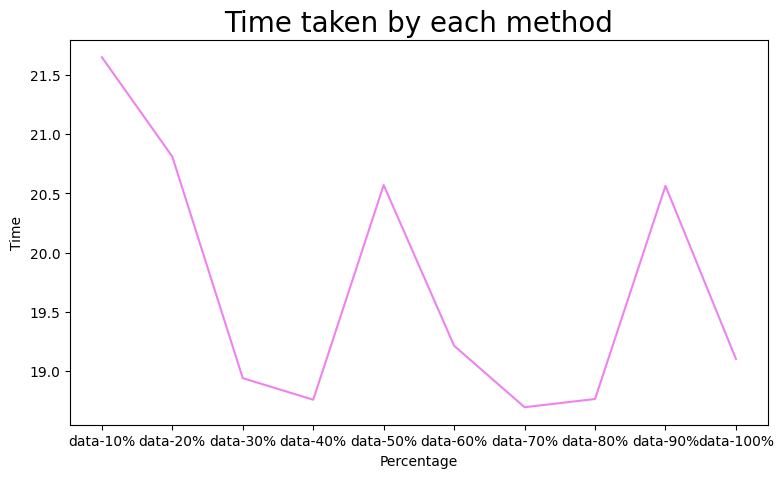

In [ ]:
import time
import matplotlib.pyplot as plt
part = []
each_part_time = []

for i in range(0, 100, 10):
    start_time = time.time()
    part.append(f"data-{i + 10}%")
    part_size = (i + 10) / 100

    # Split the data
    train_data, test_data = data.randomSplit([0.7,0.3],seed=100)

    # Prepare the feature vector
    assembler = VectorAssembler(inputCols=["distance"], outputCol="features")
    train_data = assembler.transform(train_data)

    # Initialize and train the model M1 (you can do the same for M2)
    lr = LinearRegression(featuresCol="features", labelCol="fare")
    model_M1 = lr.fit(train_data)

    print("Time for part " + str(part_size) + ":", time.time() - start_time)
    each_part_time.append(time.time() - start_time)

# Plot the execution times
fig = plt.figure(figsize=(9, 5))
plt.plot(part, each_part_time, color='violet')
plt.title("Time taken by each method", size=20)
plt.xlabel("Percentage")
plt.ylabel("Time")
plt.savefig("timetaken.png")
plt.show()


Time for part 1.0: 20.98910641670227
Time for part 1.0: 21.940760135650635
Time for part 1.0: 18.848644495010376
Time for part 1.0: 18.540790557861328
Time for part 1.0: 19.572787046432495
Time for part 1.0: 20.337162017822266
Time for part 1.0: 18.54940438270569
Time for part 1.0: 18.623161554336548
Time for part 1.0: 19.282005548477173
Time for part 1.0: 20.504183292388916


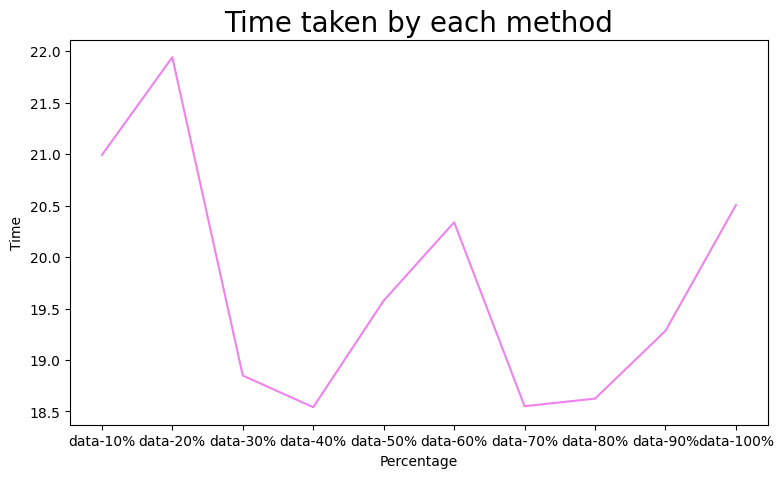

In [ ]:
part1 = []
each_part_time1 = []

for i in range(0, 100, 10):
    start_time = time.time()
    part1.append(f"data-{i + 10}%")
    part1_size = (i + 10) / 100

    # Split the data
    train_data, test_data = data.randomSplit([0.7,0.3],seed=100)

    # Prepare the feature vector
    features_column=['trip_duration_minutes','distance']
    assembler = VectorAssembler(inputCols=features_column, outputCol="features")
    train_data = assembler.transform(train_data)

    # Initialize and train the model M2 (you can do the same for M2)
    lr = LinearRegression(featuresCol="features", labelCol="fare")
    model_M1 = lr.fit(train_data)

    print("Time for part " + str(part_size) + ":", time.time() - start_time)
    each_part_time1.append(time.time() - start_time)

# Plot the execution times
fig = plt.figure(figsize=(9, 5))
plt.plot(part1, each_part_time1, color='violet')
plt.title("Time taken by each method", size=20)
plt.xlabel("Percentage")
plt.ylabel("Time")
plt.savefig("timetaken.png")
plt.show()